# Practical 09 - Recurrent Neural Networks

**Disclamer**: Some material from the suggested exercises were retrieved and adapted from the following sources:
* [Coursera Sequence Models course by DeepLearningAI](https://www.coursera.org/learn/nlp-sequence-models)
* [Pytorch Tutorial for RNNs](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html)
* [Pytorch Sentiment Analysis Tutorial](https://github.com/bentrevett/pytorch-sentiment-analysis)

In [1]:
import numpy as np

np.random.seed(1)

## Question 01


Perform a forward propagation for 

$ x^{(1)} = \begin{bmatrix} \begin{pmatrix}
4 \\ 0 \\ 0 \\ 0
\end{pmatrix}, 
 \begin{pmatrix}
0 \\ 8 \\ 2 \\ 0
\end{pmatrix}
\end{bmatrix}
$

With targets:

$ t^{(1)} = \begin{bmatrix} \begin{pmatrix}
1 \\ 0
\end{pmatrix}, 
 \begin{pmatrix}
0 \\ 1
\end{pmatrix}
\end{bmatrix}
$

Initialize all weights and biases to 0.1, using 3 units per hidden layer, initializing the hidden state to all zeros and using η = 1.0.

----

A Recurrent neural network can be seen as the repetition of a single cell. We are first going to implement the computations for a single time-step. The following figure describes the operations for a single time-step of an RNN cell. 

<img src="forward-net.png" style="width:700px;height:300px;">


**Steps to code the RNN cell**:
1. Compute the hidden state with tanh activation: $a^{\langle t \rangle} = \tanh(W_{aa} a^{\langle t-1 \rangle} + W_{ax} x^{\langle t \rangle} + b_a)$.
2. Using your new hidden state $a^{\langle t \rangle}$, compute the prediction $\hat{y}^{\langle t \rangle} = softmax(W_{ya} a^{\langle t \rangle} + b_y)$.
3. Return $a^{\langle t \rangle}$ and $y^{\langle t \rangle}$ 


In [2]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)


def rnn_cell_forward(xt, a_prev, Wax, Waa, Wya, ba, by):
    """
    Implements a single forward step of the RNN-cell
    
    Arguments:
        xt -- your input data at timestep "t", numpy array of shape (n_x).
        a_prev -- Hidden state at timestep "t-1", numpy array of shape (n_a)
        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
        ba --  Bias, numpy array of shape (n_a, 1)
        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)

    Returns:
        a_next -- next hidden state, of shape (n_a)
        yt_pred -- prediction at timestep "t", numpy array of shape (n_y)

    """
    
    # compute next activation state
    a_next = np.tanh(np.dot(Wax, xt) + np.dot(Waa, a_prev) + ba)
    
    # compute output of the current cell
    yt_pred = softmax(np.dot(Wya, a_next) + by)

    return a_next, yt_pred

You can see an RNN as the repetition of the cell you've just built. If your input sequence of data is carried over 10 time steps, then you will copy the RNN cell 10 times. Each cell takes as input the hidden state from the previous cell ($a^{\langle t-1 \rangle}$) and the current time-step's input data ($x^{\langle t \rangle}$). It outputs a hidden state ($a^{\langle t \rangle}$) and a prediction ($y^{\langle t \rangle}$) for this time-step.


<img src="rnn_forward.png" style="width:800px;height:300px;">



Now, we are going to code the RNN forward propagation over the sequence

**Steps**:
1. Create a vector of zeros ($a$) that will store all the hidden states computed by the RNN.
2. Initialize the "next" hidden state as $a_0$ (initial hidden state).
3. Start looping over each time step, your incremental index is $t$ :
    - Update the "next" hidden state and the cache by running `rnn_cell_forward`
    - Keep a history of the parameters for the gradient update
    - Store the "next" hidden state in $a$ ($t^{th}$ position) 
    - Store the prediction in y
4. Return $a$, $y$ and history

In [3]:
def rnn_forward(x, a0, Wax, Waa, Wya, ba, by):
    """
    Implement the forward propagation of the recurrent neural network

    Arguments:
        x -- Input data for every time-step, of shape (n_x, m, T_x).
        a0 -- Initial hidden state, of shape (n_a, m)
        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
        ba --  Bias numpy array of shape (n_a, 1)
        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)

    Returns:
        a -- Hidden states for every time-step, numpy array of shape (n_a, m, T_x)
        y_pred -- Predictions for every time-step, numpy array of shape (n_y, m, T_x)
        history -- tuple of values needed for the backward pass, contains (list of caches, x)
    """
    
    # Initialize "history" which will contain the list the parameters in each time-step
    history = []
    
    # Retrieve dimensions from shapes of x and Wy
    n_x, T_x = x.shape
    n_y, n_a = Wya.shape
        
    # initialize "a" and "y_pred" with zeros
    a = np.zeros((n_a, T_x))
    y_pred = np.zeros((n_y, T_x))
    
    # Initialize a_next
    a_next = a0
    
    # loop over all time-steps
    for t in range(T_x):
        
        # Update next hidden state, compute the prediction
        a_prev = a_next
        a_next, yt_pred = rnn_cell_forward(x[:,t], a_next, Wax, Waa, Wya, ba, by)
            
        # Store the time-step in the history
        step_parms = (a_next, a_prev, x[:,t], Wax, Waa, Wya, ba, by)
        history.append(step_parms)

        # Save the value of the new "next" hidden state in a (≈1 line)
        a[:, t] = a_next
        
        # Save the value of the prediction in y
        y_pred[:, t] = yt_pred

    return a, y_pred, history

In [4]:
# Let's run the rnn_forward for a sequence of 10 elements.
inputs = np.array([[4, 0, 0, 0], [0, 8, 2, 0]]).transpose()

a0 = .1 * np.ones(3)
Waa = .1 * np.ones((3,3))
Wax = .1 * np.ones((3,4))
Wya = .1 * np.ones((2,3))
ba = .1 * np.ones(3)
by = .1 * np.ones(2)

In [5]:
a, y_pred, history = rnn_forward(inputs, a0, Wax, Waa, Wya, ba, by)

print("a = ", a)
print("a.shape = ", a.shape)
print()
print("y_pred =", y_pred)
print("y_pred.shape = ", y_pred.shape)


a =  [[0.48538109 0.84704925]
 [0.48538109 0.84704925]
 [0.48538109 0.84704925]]
a.shape =  (3, 2)

y_pred = [[0.5 0.5]
 [0.5 0.5]]
y_pred.shape =  (2, 2)


## Question 02

Use PyTorch to implement an RNN cell and use it to generate random person names using the file `names.txt` as training examples.

In [6]:
import torch
import torch.nn as nn
from torch import optim


# Vanilla RNN implementation
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.tanh= nn.Tanh()
        self.o2o = nn.Linear(hidden_size, output_size)
        self.initial_hidden = nn.Parameter(
            torch.zeros(1, hidden_size)
        )
        self.softmax = nn.LogSoftmax(dim=1)

    def single_forward(self, input, hidden):
        input_combined = torch.cat((input, hidden), 1)
        hidden = self.tanh(self.i2h(input_combined))
        output = self.o2o(hidden)
        output = self.softmax(output)
        return output, hidden
    
    def forward(self, input_line_tensor):
        
        outputs = []
        
        hidden = self.initial_hidden
        
        for x_t in input_line_tensor:
            output, hidden = self.single_forward(
                x_t, hidden)
            outputs.append(output)
            
        return outputs
            

In [7]:
# all letters to work with the Portuguese names from the train file
all_letters = 'abcdefghijklmnopqrstuvxwyzáàãçéêíóõôú'
n_letters = len(all_letters) + 1 # Plus EOS marker

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes).unsqueeze(-1)

# Read the list of names
with open("names.txt") as file:
    names = [name.lower().strip() for name in file.readlines()]   
    
print(names)

['francisco', 'maria', 'joão', 'leonor', 'afonso', 'matilde', 'tomás', 'carolina', 'duarte', 'alice', 'gabriel', 'benedita', 'santiago', 'beatriz', 'lourenço', 'mariana', 'rodrigo', 'francisca', 'miguel', 'sofia', 'martim', 'margarida', 'vicente', 'laura', 'mateus', 'camila', 'lucas', 'clara', 'guilherme', 'ana', 'salvador', 'inês', 'pedro', 'lara', 'gonçalo', 'madalena', 'dinis', 'diana', 'rafael', 'vitória', 'gustavo', 'constança', 'bernardo', 'eva', 'josé', 'mafalda', 'diogo', 'gabriela', 'manuel', 'bianca', 'tiago', 'valentina', 'vasco', 'joana', 'henrique', 'íris', 'simão', 'sara', 'diego', 'luana', 'antónio', 'ariana', 'david', 'letícia', 'daniel', 'rita', 'leonardo', 'júlia', 'enzo', 'carlota', 'xavier', 'carminho', 'eduardo', 'luísa', 'andré', 'ema', 'luís', 'olívia', 'isaac', 'helena', 'matias', 'yara', 'valentim', 'aurora', 'artur', 'yasmin', 'samuel', 'emma', 'kevin', 'teresa', 'frederico', 'mara', 'filipe', 'catarina', 'matheus', 'caetana', 'lorenzo', 'melissa', 'noah', 'al

In [8]:
from tqdm import tqdm
from random import shuffle, choice

train_data = [ (inputTensor(name),targetTensor(name)) for name in names ]

hidden_size = 128
num_epochs = 500
criterion = nn.NLLLoss()
learning_rate = 0.0005
model = RNN(n_letters, hidden_size, n_letters)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


def train(model, train_data, num_epochs, optimizer, criterion ):
    all_losses = []

    for epoch in tqdm(range(num_epochs)):

        shuffle(train_data)
        loss_agg = 0

        for input_line_tensor, target_line_tensor in train_data:

            optimizer.zero_grad()

            outputs = model.forward(input_line_tensor)

            loss = torch.stack(
                [ criterion(o_i, t_i) for o_i ,t_i in zip(outputs, target_line_tensor)]
            ).sum()

            loss.backward()
            optimizer.step()
            
            loss_agg += loss.item()/ input_line_tensor.size(0)
        
        all_losses.append(loss_agg)
            
    return all_losses

all_losses = train(
    model=model, 
    train_data=train_data, 
    num_epochs=num_epochs, 
    optimizer=optimizer, 
    criterion=criterion)

100%|██████████| 500/500 [01:34<00:00,  5.29it/s]


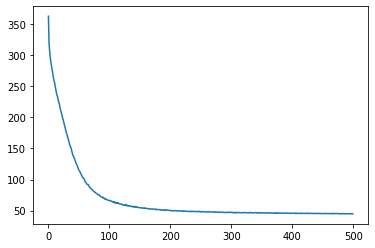

In [9]:
import matplotlib.pyplot as plt

# Let's inpsect the training loss
plt.figure()
plt.plot(all_losses)

In [10]:
max_length = 20

# Sample from a category and starting letter
def sample(start_letter='a'):
    with torch.no_grad():  # no need to track history in sampling
        input = inputTensor(start_letter)
        hidden = model.initial_hidden

        output_name = start_letter

        for i in range(max_length):
            output, hidden = model.single_forward(input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# generate 10 random names
for _ in range(10):
    # choose a starting letter from a-z
    start_letter = choice(all_letters[:26])
    print(sample(start_letter))

pilar
francisca
victória
pilar
carlos
kevin
kevin
yasmin
francisca
martim


## Question 03

In [11]:
import torch
from torchtext.legacy import data , datasets

TEXT = data.Field()
LABEL = data.LabelField(dtype = torch.float)

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

train_data, valid_data = train_data.split()

# build the vocabulary
TEXT.build_vocab(train_data, max_size = 20_000)
LABEL.build_vocab(train_data)


print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 17500
Number of validation examples: 7500
Number of testing examples: 25000


In [12]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

In [13]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim)       
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):

        #text = [sent len, batch size]
        #embedded = [sent len, batch size, emb dim]
        embedded = self.embedding(text)
                
        #output = [sent len, batch size, hid dim * num directions]
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        output, (hidden, cell) = self.rnn(embedded)
        
        #hidden = [batch size, hid dim * num directions]
        hidden = hidden[-1,:,:]
                
        return self.fc(hidden)

In [14]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM)

model = model.to(device)

In [15]:
print(model)

RNN(
  (embedding): Embedding(20002, 100)
  (rnn): LSTM(100, 256)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


In [16]:
# let's run a forward pass to one batch to check the predictions and how to work with them.
for batch in train_iterator:
    text = batch.text
    target = batch.label
    predictions = model(text)
    break

In [17]:
print(predictions.shape)
print(target.shape)

torch.Size([64, 1])
torch.Size([64])


In [18]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [19]:
binary_accuracy(predictions.squeeze(1), target)

tensor(0.4688)

In [20]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text = batch.text
        
        predictions = model(text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [21]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text = batch.text
            
            predictions = model(text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [22]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

In [ ]:
optimizer = optim.Adam(model.parameters())

# Train for 5 epochs
for epoch in range(5):

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    

In [24]:
test_loss, test_acc = evaluate(model, test_iterator, criterion)
print(f'\t Val. Loss: {test_loss:.3f} |  Val. Acc: {test_acc*100:.2f}%')

	 Val. Loss: 0.401 |  Val. Acc: 82.33%


Let's do some changes to use a bidirectional LSTM and implement some other improvements.

In [25]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bidirectional = bidirectional
        
        self.rnn = nn.LSTM(embedding_dim, 
                            hidden_dim, 
                            num_layers=n_layers, 
                            bidirectional=bidirectional, 
                            dropout=dropout)
        
        if self.bidirectional:
            self.fc = nn.Linear(hidden_dim * 2, output_dim)
        else:
            self.fc = nn.Linear(hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):

        #text = [sent len, batch size]
        #embedded = [sent len, batch size, emb dim]
        embedded = self.dropout(self.embedding(text))
                
        #output = [sent len, batch size, hid dim * num directions]
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        output, (hidden, cell) = self.rnn(embedded)
        
        #hidden = [batch size, hid dim * num directions]
        if self.bidirectional:
            #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
                
        return self.fc(hidden)

In [26]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 1
BIDIRECTIONAL = True
DROPOUT = 0.5

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT)

model = model.to(device)

In [ ]:
optimizer = optim.Adam(model.parameters())

for epoch in range(5):

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

In [ ]:
test_loss, test_acc = evaluate(model, test_iterator, criterion)
print(f'\t Val. Loss: {test_loss:.3f} |  Val. Acc: {test_acc*100:.2f}%')